In [1]:
from __future__ import division
from __future__ import print_function

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random
from IPython import display
from sklearn import datasets, preprocessing
import tensorflow as tf

from tqdm import tqdm_notebook

In [4]:
np.random.seed(23)

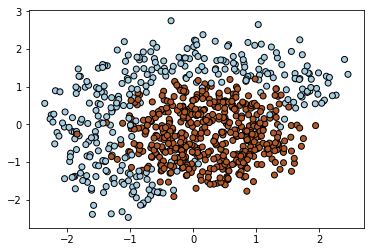

In [5]:
(X, y) = datasets.make_circles(n_samples=1024, shuffle=True, noise=0.2, factor=0.4)
ind = np.logical_or(y==1, X[:,1] > X[:,0] - 0.5)
X = X[ind,:]
X = preprocessing.scale(X)
y = y[ind]
y = 2*y - 1
plt.scatter(X[:, 0], X[:, 1], cmap=plt.cm.Paired, c=y, edgecolors='black')

plt.show()

In [6]:
h = 0.1 # I reduced h because my GPU memory never asked for this
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

def visualize(X, y, w, loss, n_iter):
    plt.clf()
    plt.figure(figsize=(20, 8))
    
    X_var = tf.placeholder(tf.float32, shape=[None, 2], name='X')
    w_place = tf.placeholder(tf.float32, shape=[6], name='Y')
    
    preds = classify(X_var, w_place)
    
    with tf.Session() as sess:
        Z = sess.run(preds, feed_dict={X_var:np.c_[xx.ravel(), yy.ravel()], w_place:w})

    Z = Z.reshape(xx.shape)
    
    plt.subplot(1,2,1)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, edgecolors='black')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.subplot(1,2,2)
    plt.plot(loss)
    plt.grid()
    ymin, ymax = plt.ylim()
    plt.ylim(0, ymax)
    display.clear_output(wait=True)
    display.display(plt.gcf())

**Your task starts here**

First, let's write a function that predicts class for given X.

Since the problem above isn't linearly separable, we add quadratic features to the classifier. This transformation is implemented in the __expand__ function.

__Don't forget to expand X inside classify and other functions__

Sample classification should not be much harder than computation of sign of dot product.

In [7]:
def expand(X):
    X0 = tf.transpose(tf.gather(tf.transpose(X), [0]))
    X1 = tf.transpose(tf.gather(tf.transpose(X), [1]))
    return tf.concat([X, X ** 2, X0 * X1, tf.ones(shape=(tf.shape(X)[0], 1))], axis=1)

def classify(X, w):
    """
    Given feature matrix X [n_samples, 2] and weight vector w [6],
    return an array of +1 or -1 predictions
    """
    X_exp = expand(X)    
    mult = tf.matmul(X_exp, tf.reshape(w, shape=(6,1)))
    return tf.where(tf.greater(mult, 0), tf.ones(shape=(tf.shape(X)[0], 1)), -tf.ones(shape=(tf.shape(X)[0], 1)))

The loss you should try to minimize is the Hinge Loss:

$$ L =  {1 \over N} \sum_{i=1}^N max(0,1-y_i \cdot  w^T x_i) $$



In [8]:
def compute_loss(X, y, w):
    """
    Given feature matrix X [n_samples,2], target vector [n_samples] of +1/-1,
    and weight vector w [6], compute scalar loss function using formula above.
    """
    X_exp = expand(X)    
    preds = tf.ones_like(y) - tf.multiply(y, tf.matmul(X_exp, tf.reshape(w, shape=(6,1)))) 
    
    return tf.reduce_mean(tf.maximum(tf.zeros_like(y), preds))

def compute_grad(X, y, w):
    """
    Given feature matrix X [n_samples,2], target vector [n_samples] of +1/-1,
    and weight vector w [6], compute vector [6] of derivatives of L over each weights.
    """
    X_exp = expand(X)
    mult = tf.multiply(y, X_exp)
    preds = tf.ones_like(X_exp) - tf.multiply(w, tf.multiply(y, X_exp))
    
    return tf.reduce_mean(tf.where(tf.less(preds, tf.zeros_like(X_exp)), tf.zeros_like(X_exp), -mult), axis=0)

### Training
Find an optimal learning rate for gradient descent for given batch size. 

You can see the example of correct output below this cell before you run it.

**Don't change the batch size!**

In [9]:
X_place = tf.placeholder(tf.float32, shape=(None, 2), name='X_batch')
y_place = tf.placeholder(tf.float32, shape=(None), name='y_batch')

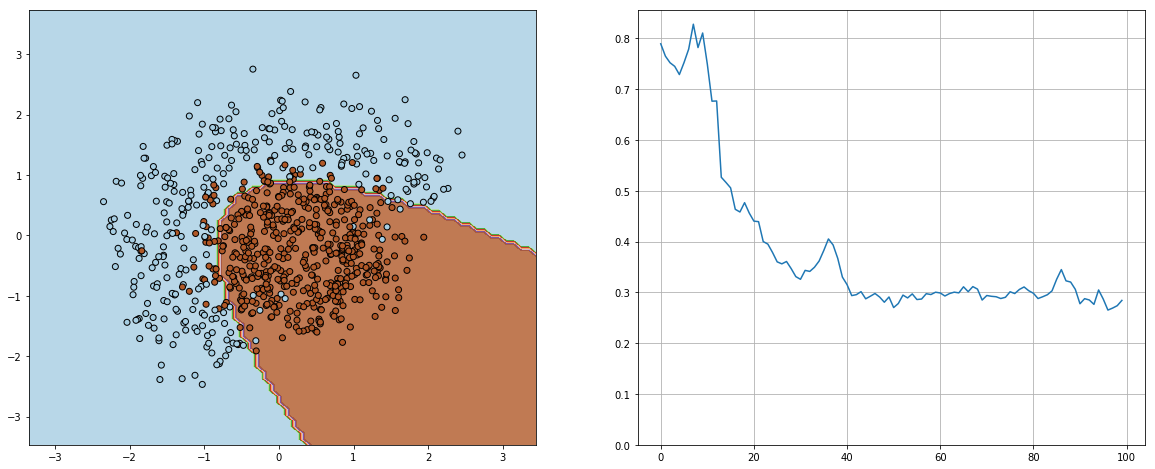

In [11]:
alpha = 0.1 # learning rate

w_var = tf.Variable([1,0,0,0,0,0], dtype=tf.float32, name='w')

n_iter = 100
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12,5))

#functor are much faster with tf
loss_func = compute_loss(X_place, y_place, w_var)
grad_func = compute_grad(X_place, y_place, w_var)
update_weights_func = tf.assign(w_var, w_var - alpha * grad_func)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for i in tqdm_notebook(range(n_iter)):
        ind = random.sample(range(X.shape[0]), batch_size)
        
        X_batch = X[ind, :]
        y_batch = y[ind].reshape((batch_size, 1))
        
        loss[i] = sess.run(loss_func, feed_dict={X_place:X, y_place:y.reshape(-1, 1)})
        sess.run(update_weights_func, feed_dict={X_place:X_batch, y_place:y_batch})
    
    visualize(X, y, w_var.eval(), loss, n_iter)
    plt.clf()


Implement gradient descent with momentum and test it's performance for different learning rate and momentum values.

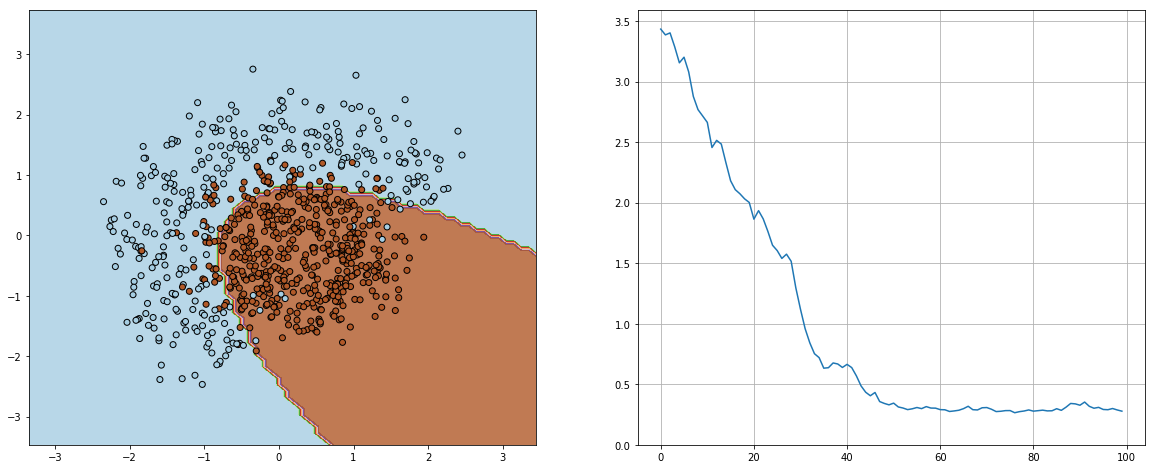

In [12]:
w_var = tf.Variable(np.random.normal(size=6), dtype=tf.float32, name='weight')
u_var = tf.Variable(np.zeros(shape=6), dtype=tf.float32, name='momentum')

alpha = 0.1 # learning rate
mu    = 0.05 # momentum

loss_func = compute_loss(X_place, y_place, w_var)
grad_func = compute_grad(X_place, y_place, w_var)
update_momentum_func = tf.assign(u_var, mu*u_var + alpha*grad_func)
update_weights_func = tf.assign(w_var, w_var - update_momentum_func)

n_iter = 100
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12,5))
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for i in tqdm_notebook(range(n_iter)):
        ind = random.sample(range(X.shape[0]), batch_size)
        
        X_batch = X[ind]
        y_batch = y[ind].reshape((batch_size, 1))
        
        loss[i] = sess.run(loss_func, feed_dict={X_place:X, y_place:y.reshape(-1, 1)})
        sess.run(update_weights_func, feed_dict={X_place:X_batch, y_place:y_batch})
    
    visualize(X, y, w_var.eval(), loss, n_iter)
    plt.clf()

Same task but for Nesterov's accelerated gradient:

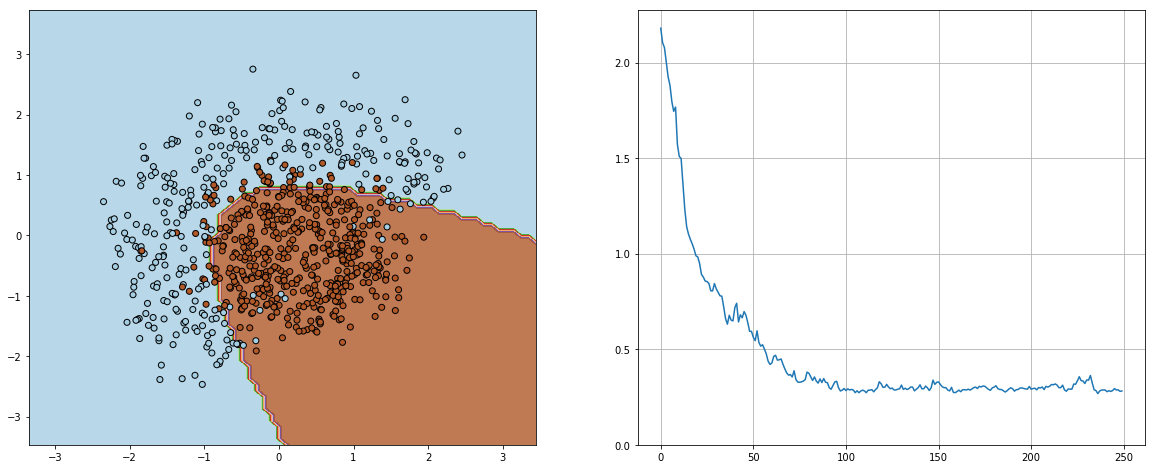

In [13]:
w_var = tf.Variable(np.random.normal(size=6), dtype=tf.float32, name='weight')
u_var = tf.Variable(np.zeros(shape=6), dtype=tf.float32, name='momentum')

alpha = 0.1 # learning rate
mu    = 0.05 # momentum

loss_func = compute_loss(X_place, y_place, w_var)
grad_func = compute_grad(X_place, y_place, w_var - mu*u_var)
update_momentum_func = tf.assign(u_var, mu*u_var + alpha*grad_func)
update_weights_func = tf.assign(w_var, w_var - update_momentum_func)

n_iter = 250
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12,5))
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for i in tqdm_notebook(range(n_iter)):
        ind = random.sample(range(X.shape[0]), batch_size)
        
        X_batch = X[ind]
        y_batch = y[ind].reshape((batch_size, 1))
        
        loss[i] = sess.run(loss_func, feed_dict={X_place:X, y_place:y.reshape(-1, 1)})
        sess.run(update_weights_func, feed_dict={X_place:X_batch, y_place:y_batch})
    
    visualize(X, y, w_var.eval(), loss, n_iter)
    plt.clf()

Same task but for AdaGrad:

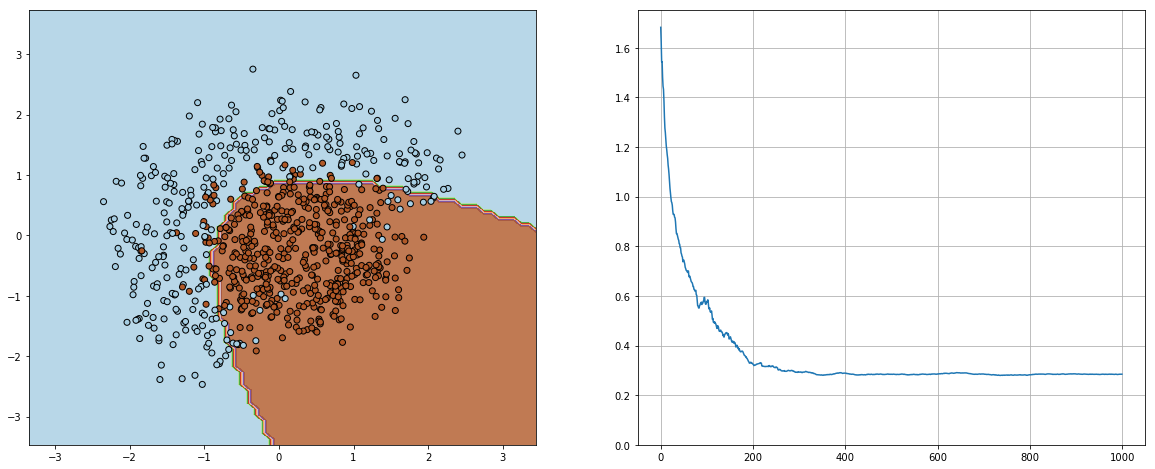

In [15]:
w_var = tf.Variable(np.random.normal(size=6), dtype=tf.float32, name='weight')
p_var = tf.Variable(np.zeros(shape=6), dtype=tf.float32, name='penalty')

alpha = 0.1 # learning rate

loss_func = compute_loss(X_place, y_place, w_var)
grad_func = compute_grad(X_place, y_place, w_var)

update_penalty_func = tf.assign(p_var, p_var + tf.square(grad_func))
update_weights_func = tf.assign(w_var, w_var - alpha*grad_func/(tf.sqrt(update_penalty_func) + 10e-5))

n_iter = 1000
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12,5))
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for i in tqdm_notebook(range(n_iter)):
        ind = random.sample(range(X.shape[0]), batch_size)
        
        X_batch = X[ind]
        y_batch = y[ind].reshape((batch_size, 1))
        
        loss[i] = sess.run(loss_func, feed_dict={X_place:X, y_place:y.reshape(-1, 1)})
        sess.run(update_weights_func, feed_dict={X_place:X_batch, y_place:y_batch})
    
    visualize(X, y, w_var.eval(), loss, n_iter)
    plt.clf()

Same task but for AdaDelta:

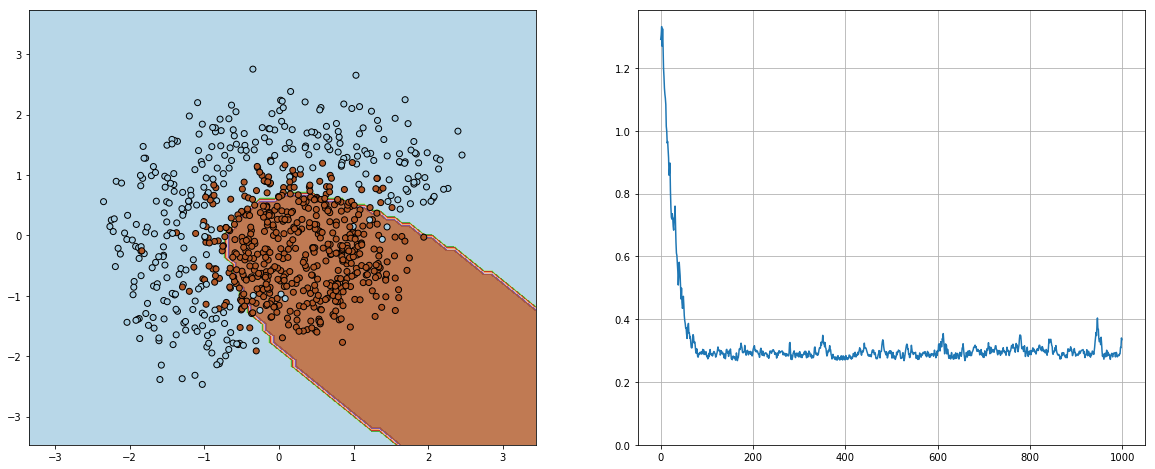

In [16]:
w_var = tf.Variable(np.random.normal(size=6), dtype=tf.float32, name='weight')
p_var = tf.Variable(np.zeros(shape=6), dtype=tf.float32, name='penalty')

alpha = 0.05 # learning rate
beta = 0.5

loss_func = compute_loss(X_place, y_place, w_var)
grad_func = compute_grad(X_place, y_place, w_var)

update_penalty_func = tf.assign(p_var, p_var*beta + (1-beta)*tf.square(grad_func))
update_weights_func = tf.assign(w_var, w_var - alpha*grad_func/(tf.sqrt(update_penalty_func) + 10e-5))

n_iter = 1000
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12,5))
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for i in tqdm_notebook(range(n_iter)):
        ind = random.sample(range(X.shape[0]), batch_size)
        
        X_batch = X[ind]
        y_batch = y[ind].reshape((batch_size, 1))
        
        loss[i] = sess.run(loss_func, feed_dict={X_place:X, y_place:y.reshape(-1, 1)})
        sess.run(update_weights_func, feed_dict={X_place:X_batch, y_place:y_batch})
    
    visualize(X, y, w_var.eval(), loss, n_iter)
    plt.clf()

Same task for Adam algorithm. You can start with beta = 0.9 and mu = 0.999

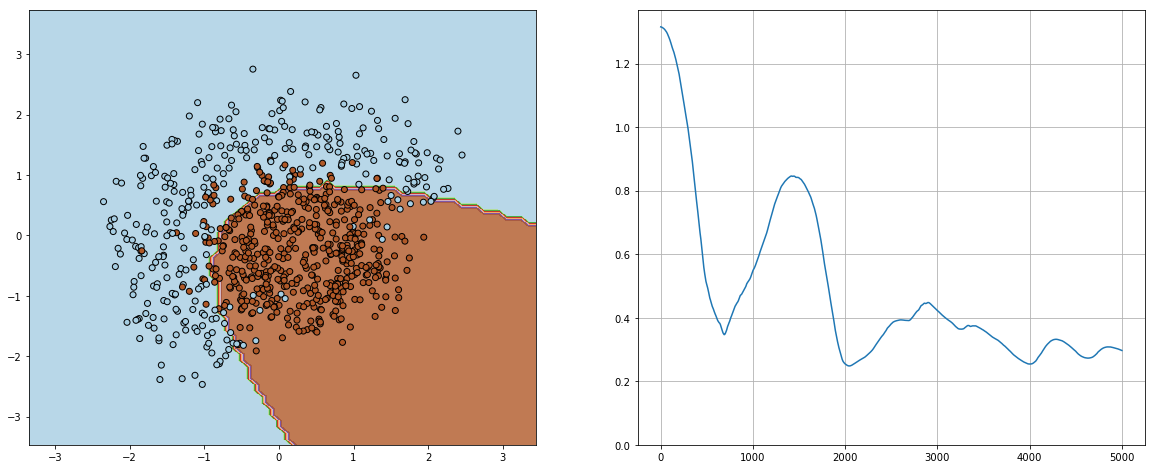

In [17]:
w_var = tf.Variable(np.random.normal(size=6), dtype=tf.float32, name='weight')
u_var = tf.Variable(np.zeros(shape=6), dtype=tf.float32, name='momentum')
d_var = tf.Variable(np.zeros(shape=6), dtype=tf.float32, name='decay')

alpha = 0.02 # learning rate
beta = 0.9  # (beta1 coefficient in original paper) exponential decay rate for the 1st moment estimates
mu   = 0.999  # (beta2 coefficient in original paper) exponential decay rate for the 2nd moment estimates

loss_func = compute_loss(X_place, y_place, w_var)
grad_func = compute_grad(X_place, y_place, w_var)

update_momentum_func = tf.assign(u_var, mu*u_var + (1 - mu)*grad_func)
update_decay_func = tf.assign(d_var, beta*d_var + (1-beta)*tf.square(grad_func))
update_weights_func = tf.assign(w_var, w_var - alpha*update_momentum_func/(tf.sqrt(update_decay_func)+10e-5))

n_iter = 5000
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12,5))
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for i in tqdm_notebook(range(n_iter)):
        ind = random.sample(range(X.shape[0]), batch_size)
        
        X_batch = X[ind]
        y_batch = y[ind].reshape((batch_size, 1))
        
        loss[i] = sess.run(loss_func, feed_dict={X_place:X, y_place:y.reshape(-1, 1)})
        sess.run(update_weights_func, feed_dict={X_place:X_batch, y_place:y_batch})
    
    visualize(X, y, w_var.eval(), loss, n_iter)
    plt.clf()